# Experiments
This notebook contains some of the experiments that were performed for the Master Thesis


In [1]:
from datasets import load_from_disk, concatenate_datasets
from tatoeba import analysis

## Merge datasets
Due to the large amount of time needed to generate the translations, they are performed for each direction individually. Run the following merge in order to combine the two datasets into one for the remaining analyses if that has not already been done.

In [7]:
ko_data = load_from_disk("./data/tatoeba_de_ko_labelled")
de_data = load_from_disk("./data/tatoeba_ko_de_labelled")

In [22]:
remove_cols = [col for col in ko_data.column_names if col in de_data.column_names]
disjunct_de = de_data.remove_columns(column_names=remove_cols)
merged_data = concatenate_datasets([ko_data, disjunct_de], axis=1)

In [27]:
merged_data.save_to_disk("./data/tatoeba_merged")

Saving the dataset (0/4 shards):   0%|          | 0/996350 [00:00<?, ? examples/s]

## Explore Dataset
First the dataset is explored to obtain some base level statistics

In [2]:
ds = load_from_disk("./data/tatoeba_merged")

In [3]:
print(ds)

Dataset({
    features: ['id', 'source', 'target', 'ko_nmt', 'chrf_ko', 'bleu_ko', 'comet_ko', 'upos_tags_source', 'pos_tags_source', 'ws_tokens_source', 'sent_ids_source', 'de_formality', 'de_formality_map', 'upos_tags_target', 'pos_tags_target', 'ws_tokens_target', 'sent_ids_target', 'upos_tags_ko_nmt', 'pos_tags_ko_nmt', 'ws_tokens_ko_nmt', 'sent_ids_ko_nmt', 'ko_formality', 'ko_formality_map', 'ko_formality_nmt', 'ko_formality_map_nmt', 'de_nmt', 'chrf_de', 'bleu_de', 'comet_de', 'upos_tags_de_nmt', 'pos_tags_de_nmt', 'ws_tokens_de_nmt', 'sent_ids_de_nmt', 'de_formality_nmt', 'de_formality_map_nmt'],
    num_rows: 996350
})


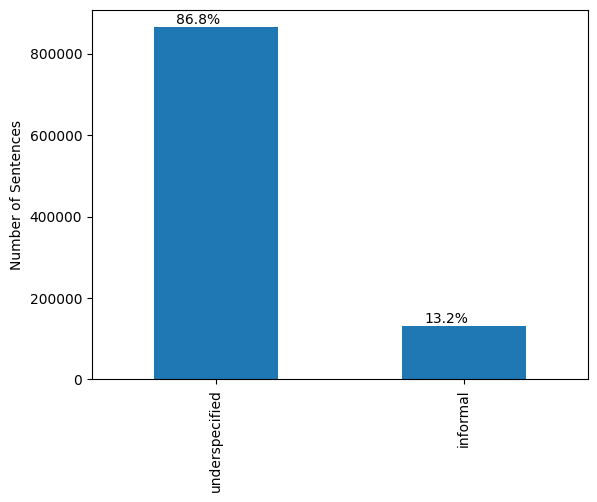

In [4]:
analysis.get_formality_plot(ds, "de_formality")

In [ ]:
analysis.get_formality_plot(ds, "ko_formality", ax_annotate_vals=(0.3,2500))

In [ ]:
analysis.get_cross_formality_plot(ds, "ko_formality", "de_formality", exclude_vals=["ambiguous"], form_col_desc="Korean formality", cross_col_desc="German formality")

In [ ]:
ds = ds.filter(lambda ex: ex["de_formality"] != "ambiguous" and ex["ko_formality"] != "ambiguous")

In [ ]:
analysis.get_formality_plot(ds, "de_formality_nmt")

In [ ]:
analysis.get_formality_plot(ds, "ko_formality_nmt")

In [ ]:
analysis.get_cross_formality_plot(ds, "de_formality_nmt", "ko_formality_nmt", form_col_desc="Korean formality", cross_col_desc="German formality")